In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
np.random.seed(123)

In [2]:
path = '/Users/rohitsharma/Desktop/poverty'
df_dhs_light = pd.read_csv(path+'/DHS_light.csv', index_col=False)

In [3]:
df = df_dhs_light[['mean_light', 'Wealth Index Factor Score']]

In [4]:
df.head()

,mean_light,Wealth Index Factor Score
0,1.51,-0.48754
1,4.62,-0.40171
2,1.03,-0.06029
3,1.37,-0.90324
4,0.00,-0.69925


In [5]:
df.columns = ['mean_light', 'WIFS']

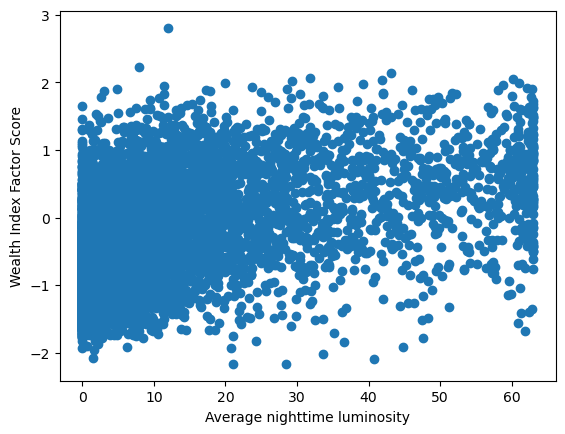

In [6]:
plt.scatter(x='mean_light', y='WIFS', data=df)
plt.ylabel('Wealth Index Factor Score');plt.xlabel('Average nighttime luminosity')
plt.show()

In [7]:
print('percentage of zero light intensity in the satellite image =',
      len(df[df['mean_light']==0])/len(df)*100 ,'%')

percentage of zero light intensity in the satellite image = 13.333333333333334 %


Text(0.5, 0, 'Wealth Index Factor Score')

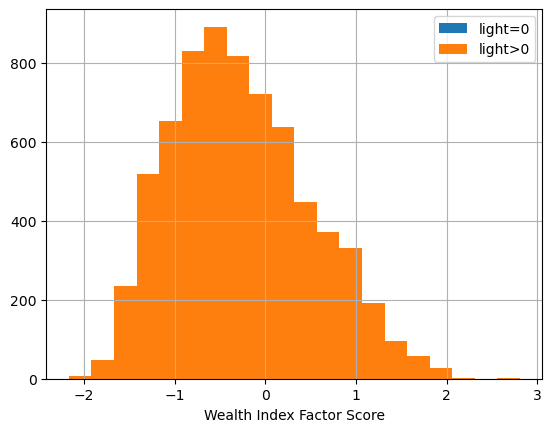

In [8]:
ax=df[df['mean_light']==0]['WIFS'].hist(bins=20, label=['light=0'])
df[df['mean_light']!=0]['WIFS'].hist(bins=20, ax=ax, label=['light>0'])
plt.legend()
plt.xlabel('Wealth Index Factor Score')

In [9]:
df.head()

,mean_light,WIFS
0,1.51,-0.48754
1,4.62,-0.40171
2,1.03,-0.06029
3,1.37,-0.90324
4,0.00,-0.69925


In [10]:
from sklearn.model_selection import train_test_split
X=df[['mean_light']].values.reshape((-1, 1))
y=df[['WIFS']].values.reshape((-1, 1))

In [11]:
from sklearn.preprocessing import  MinMaxScaler
sc= MinMaxScaler()
X= sc.fit_transform(X)
y= y.reshape(-1,1)
y=sc.fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, lr.predict(X_test)), 2))

R2-score : 0.23


In [15]:
lasso= LassoCV(alphas=np.logspace(0, 16, 10))
lasso.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, lasso.predict(X_test)), 2))

R2-score : -0.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
ridge= RidgeCV(alphas=np.logspace(0, 3, 1000))
ridge.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, ridge.predict(X_test)), 2))

R2-score : 0.23


In [17]:
elast = ElasticNet()
elast.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, elast.predict(X_test)), 2))

R2-score : -0.0


In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, rf.predict(X_test)), 2))

/var/folders/fk/7kp4w3gn3d74k2wh9h1087k40000gn/T/ipykernel_24523/1311043616.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


R2-score : 0.1


In [19]:
xgb = XGBRegressor(learning_rate=0.015, random_state=10)
xgb.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, xgb.predict(X_test)), 2))

R2-score : 0.24


In [20]:
br = BayesianRidge()
br.fit(X_train, y_train)
print('R2-score :', round(r2_score(y_test, br.predict(X_test)), 2))

R2-score : 0.23


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
from keras import Sequential
from keras.layers import Dense
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=1, input_dim=1))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
    return regressor

2022-11-09 12:19:53.007672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
data_all = df.values
alphas_list = np.logspace(-2, 5, 8)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Lasso(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the Lasso model: {np.max(final)}')

R^2 of the Lasso model: 0.24120846481235408


In [23]:
from sklearn.linear_model import Ridge

alphas_list = np.logspace(-2, 5, 8)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the Ridge model: {np.max(final)}')

R^2 of the Ridge model: 0.24121214337807775


In [24]:
from sklearn.linear_model import ElasticNet

alphas_list = np.logspace(-2, 5, 8)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = ElasticNet(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the ElasticNet model: {np.max(final)}')

R^2 of the ElasticNet model: 0.24120714310091435


In [25]:
from sklearn.ensemble import RandomForestRegressor

n_estimators_list = [50,100,200,300,400,500]
final = []
for n_estimators in n_estimators_list:
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = RandomForestRegressor(n_estimators=n_estimators)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the Random Forest model: {np.max(final)}')

R^2 of the Random Forest model: 0.09692225771646693


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

lr_list = [0.01, 0.05,0.1,0.15,0.2,0.3]
final = []
for lr in lr_list:
    kf = KFold(n_splits=10, shuffle=True, random_state=32)
    scores = []
    for train_index, test_index in kf.split(data_all):
        train = data_all[train_index]
        test = data_all[test_index]
        xgb = XGBRegressor(learning_rate=lr)
        xgb.fit(train[:, :-1], train[:, -1])
        s = xgb.score(test[:, :-1], test[:, -1])
        #xgb_pred = xgb.predict(test[:, :-1])
        scores.append(s)
  #XGBoost_metrics = Metrics(test[:, -1], xgb_pred)
#  XGBoost_metrics.report("XGBoost")
    final.append(np.mean(scores))
print(f'R^2 of the XGbooster model: {np.max(final)}')
# Look at the R^2 scores on train and test
#print("R2 train: ", xgb.score(train[:, :-1], train[:, -1]))
#print("R2 test: ", xgb.score(test[:, :-1], test[:, -1]))

R^2 of the XGbooster model: 0.29617069967930626
